## Dataset split using `os.symlink()`

When working with large datasets consisting of separate files, we can manage dataset splits with symbolic links, essentially creating shortcuts to original files according to a desired split ratio.

The advantage is we don't need to copy or move files around, as these operations require extra computation and memory usage.  

- this script needs to be in the same folder as the `images` folder of IP102.
- NB! filenames have been changed from the originals to include class labels.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from PIL import Image
from tqdm import tqdm

%matplotlib inline

print(os.getcwd())

datapath = "images/"

c:\Users\tomas\Desktop\ip102_v1.1


In [2]:
# read category from filename
filename = "0_00213.jpg"
category = filename.split("_")[0]
print(category)

0


### Get labels

In [3]:
# read in `classes.txt.txt` with proper class names into a dict.
# these could do with a bit of sanitation.
labels = {}

with open('classes.txt.txt') as f:
    for line in f:
        # remove lead/trailing whitespace 
        stripped = line.strip()
        # collect the parts of the names together with *
        head, *rest = stripped.split()

        # we can do -1 here since our images are classed 0-101
        key = int(head) -1
        
        val = rest
        # join the names with an underscore
        labels[key] = '_'.join(val)

labels

{0: 'rice_leaf_roller',
 1: 'rice_leaf_caterpillar',
 2: 'paddy_stem_maggot',
 3: 'asiatic_rice_borer',
 4: 'yellow_rice_borer',
 5: 'rice_gall_midge',
 6: 'Rice_Stemfly',
 7: 'brown_plant_hopper',
 8: 'white_backed_plant_hopper',
 9: 'small_brown_plant_hopper',
 10: 'rice_water_weevil',
 11: 'rice_leafhopper',
 12: 'grain_spreader_thrips',
 13: 'rice_shell_pest',
 14: 'grub',
 15: 'mole_cricket',
 16: 'wireworm',
 17: 'white_margined_moth',
 18: 'black_cutworm',
 19: 'large_cutworm',
 20: 'yellow_cutworm',
 21: 'red_spider',
 22: 'corn_borer',
 23: 'army_worm',
 24: 'aphids',
 25: 'Potosiabre_vitarsis',
 26: 'peach_borer',
 27: 'english_grain_aphid',
 28: 'green_bug',
 29: 'bird_cherry-oataphid',
 30: 'wheat_blossom_midge',
 31: 'penthaleus_major',
 32: 'longlegged_spider_mite',
 33: 'wheat_phloeothrips',
 34: 'wheat_sawfly',
 35: 'cerodonta_denticornis',
 36: 'beet_fly',
 37: 'flea_beetle',
 38: 'cabbage_army_worm',
 39: 'beet_army_worm',
 40: 'Beet_spot_flies',
 41: 'meadow_moth',
 

In [4]:
# # alternatively the dictionary comprehension way
# with open("classes.txt.txt") as f:
#     a = {int(k)-1: '_'.join(v.split()) for line in f for (k,v) in [line.strip().split(None, 1)]}
# a

### Data exploration & split 

 Let's get the lengths of each class subset (# of samples per label). This will let us know how the dataset is balanced.
     

In [5]:
# https://github.com/MLWhiz/data_science_blogs/blob/master/compvisblog/Boats_DataExploration.ipynb

# print(labels)

file_list = [] 
for (dirpath, dirnames, filenames) in os.walk(datapath):
    file_list.extend(filenames)

# # or
# images = []
# for image in os.listdir(datapath):
#     images.append(image)

# print(len(images))
# print(images[0], images[-1])

In [6]:
# dict with filename as key, class as value
images = {}
for image in os.listdir(datapath):
    (val, key) = image.split("_")
    images[key] = val

# get file counts per class
from collections import Counter

images_per_class = Counter(images.values())

# accessing particular class 
counts_20 = images_per_class['20']

#print(counts_20, '\n')
#print(images_per_class)

# sort descending according to count

sorted_desc = sorted(images_per_class.items(), key=lambda x:x[1], reverse = True)

df = pd.DataFrame(sorted_desc, columns=["classID","Image count"])

df

,classID,Image count
0,101,5740
1,67,5310
2,70,5081
3,24,4094
4,51,1897
...,...,...
97,98,93
98,63,84
99,61,79
100,80,74


<AxesSubplot:title={'center':'IP102, images per target class'}>

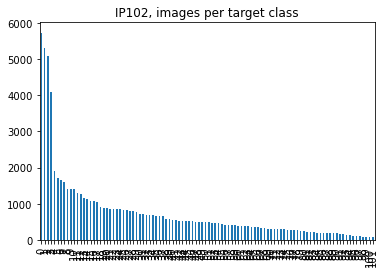

In [7]:
df["Image count"].plot.bar(title="IP102, images per target class")


### custom data split

In [8]:
# set target ratios for split. E.g., train=0.75, val=0.15, test=0.10.

# calculate the length of each subset. E.g., train_length =  0.75 * len(entire set)

# do a stratified sample of the desired size for each subset. for example sklearn Subset??
# https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/5

### original data split from .csvs

In [9]:
# read in filenames from csvs containing original data splits

train_files = []
with open('train.txt') as f:
    for line in f:
        train_files.append(line.split(" ")[0])

val_files = []
with open('val.txt') as f:
    for line in f:
        val_files.append(line.split(" ")[0])

test_files = []
with open('test.txt') as f:
    for line in f:
        test_files.append(line.split(" ")[0])

print("length of training subset:", len(train_files))
print("length of validation subset:", len(val_files))
print("length of test subset:", len(test_files))        

length of training subset: 45095
length of validation subset: 7508
length of test subset: 22619


In [11]:
# this is very slow but it works
train_paths = []
for file in file_list:
    if file.split("_")[1] in train_files:
        # print('found', file)
        full_path = os.path.join(datapath, file)
        train_paths.append(full_path)
print(len(train_paths))

45095


images/0_00002.jpg


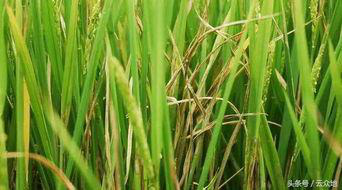

In [12]:
print(train_paths[0])
img = Image.open(train_paths[0])
img

In [13]:
# same for validation and test sets
val_paths = []
for file in file_list:
    if file.split("_")[1] in val_files:
        # print('found', file)
        full_path = os.path.join(datapath, file)
        val_paths.append(full_path)
print(len(val_paths))

test_paths = []
for file in file_list:
    if file.split("_")[1] in test_files:
        # print('found', file)
        full_path = os.path.join(datapath, file)
        test_paths.append(full_path)
print(len(test_paths))

7508
22619


we now have the lists of the paths for each file in the original subset divisions. we can make the symlinks next.

### creating symlinks

In [14]:
# create folder structure to hold split sets
dataset = "split"
print(os.path.abspath(dataset))
# using absolute paths
dataset = os.path.abspath(dataset)

train_path = os.path.join(dataset, "train")
val_path = os.path.join(dataset, "val")
test_path = os.path.join(dataset, "test")

- Make folders for each class in each dataset folder
- using `os.symlink()`, add links to original files in corresponding class folder in each dataset folder

functionalised making of symlinks

- (locally tested) Now properly creates split/phase/class folders in the right place and symlink for provided source file.

- `create_link(src, phase)`
-  `src` being an absolute path, `phase` being a string of 'train', 'val' or 'test'

In [15]:
# cleanup if needed 
if os.path.isdir(dataset):
    try:
        shutil.rmtree(dataset)
        print("removed previous split directory")
    except OSError as e:
        print("Error: %s -%s." % (e.filename, e.strerror))
    
os.mkdir(dataset)

def create_link(src, phase):

    # check src
    if os.path.isfile(src):
        #print('source exists')
        base_path = os.path.abspath(dataset)

        #print("base_path: ", base_path)
        
        # determine class index from filename
        head_tail = os.path.split(src)

        label_index = int(head_tail[1].split('_')[0])
        #print(label_index)

        img_filename_only = head_tail[1]

        labelname = labels[label_index]
        #print('class index of source: {}, labelname: {}'.format(label_index, labelname))
        phase_path = os.path.join(base_path, phase)
        #print("phase path: '%s'" % phase_path)

        # if phase path doesn't exist, it needs to be made
        if not os.path.isdir(phase_path):
            #print("making phase directory...")
            os.mkdir(phase_path)

        dest_folder_path = os.path.join(phase_path, labelname)
        #("dest folder path: {}, is abs: {}".format(dest_folder_path, os.path.isabs(dest_folder_path)))

        # if destination folder doesn't exist, make it
        if not os.path.exists(dest_folder_path):
             #print("making class directory...")
             os.mkdir(dest_folder_path)
        
        # create destination path
        link_path = os.path.join(dest_folder_path, img_filename_only)
        link_path = os.path.abspath(link_path)
        #print("link path:", link_path)
        
        # make link
        #print("making symlink at", link_path)
        os.symlink(src, link_path)
        
    else:
        print('src file not found')

removed previous split directory


Next, we iterate over the image path lists of each subset and call `create_link()` for each.
- note that on Windows you need to run whatever you're running this notebook on as administrator.

In [16]:
# training subset
for path in tqdm(train_paths):
    create_link(path, "train")
print("Done!")

100%|██████████| 45095/45095 [00:22<00:00, 2002.55it/s]

Done!


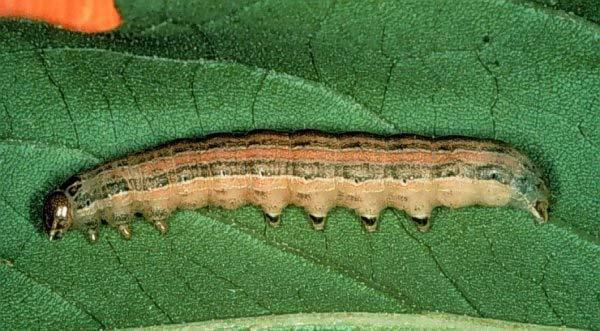

In [8]:
# does a link work?

# to access the target of the symlink, use os.readlink(link path)
link = os.readlink(r'C:\Users\tomas\Desktop\ip102_v1.1\split\train\alfalfa_seed_chalcid\55_40022.jpg')

img = Image.open(link)
img